In [1]:
# gsarma and travs 5/2015
# Doing some hello world testing with sciunit
# notebook from rgerkin
# http://nbviewer.ipython.org/github/scidash/neuronunit/blob/master/scratch.ipynb

In [2]:
%matplotlib inline
import os,sys

## Basic SciUnit model testing examples

In [3]:
import sciunit, sciunit.capabilities, sciunit.models, sciunit.scores

In [4]:
class EqualsTest(sciunit.Test):
    """Produces a boolean score if the model predicts 
    the same number as the observation."""   
    required_capabilities = (sciunit.capabilities.ProducesNumber,)
    
    def generate_prediction(self, model):
        return model.produce_number()
    
    score_type = sciunit.scores.BooleanScore
    def compute_score(self, observation, prediction):
        return self.score_type(observation == prediction)

In [5]:
equals_one_test = EqualsTest(1)
equals_two_test = EqualsTest(2)
print(equals_one_test, equals_two_test)

EqualsTest (EqualsTest) EqualsTest (EqualsTest)


In [6]:
one_model = sciunit.models.ConstModel(1)
two_model = sciunit.models.ConstModel(2)
three_model = sciunit.models.ConstModel(3)
print(one_model, two_model, three_model)

ConstModel (ConstModel) ConstModel (ConstModel) ConstModel (ConstModel)


In [7]:
one_one_score = equals_one_test.judge(one_model)
one_two_score = equals_two_test.judge(one_model)
print(one_one_score, one_two_score)

Pass Fail


In [8]:
print(one_one_score.model, one_one_score.test)

ConstModel (ConstModel) EqualsTest (EqualsTest)


In [9]:
suite = sciunit.TestSuite("suite", [equals_one_test, equals_two_test])

In [10]:
matrix = suite.judge([one_model, two_model, three_model])
print(matrix[equals_one_test])
print(matrix[two_model])

(Pass, Fail, Fail)
(Fail, Pass)


In [11]:
matrix.view()

,EqualsTest (EqualsTest),EqualsTest (EqualsTest)
ConstModel (ConstModel),Pass,Fail
ConstModel (ConstModel),Fail,Pass
ConstModel (ConstModel),Fail,Fail


##Running models and getting IV output using neuronunit and pyNeuroML

In [12]:
try:
    import neuronunit
except ImportError: # NeuronUnit is not in PYTHONPATH.  
    HOME = '/Users/rgerkin/dev'
    sys.path.append(HOME) # Path where neuronunit is located. 
    import neuronunit
    
try:
    import pyneuroml
except ImportError:
    HOME = '/Users/rgerkin/dev'
    sys.path.append(HOME+'/pyNeuroML') # Path where pyneuroml is located. 
    import pyneuroml

In [13]:
from neuronunit.nml import jnml

In [14]:
from pyneuroml.analysis import NML2ChannelAnalysis

In [15]:
ca_channel_nml = os.path.join(HOME,'ChannelWorm_tests/models/Cav1.channel.nml')
channel_id = 'ca_boyle'
xml_file_name = NML2ChannelAnalysis.run(channelFiles=[ca_channel_nml],
                                        channelId=channel_id,
                                        temperature=34,
                                        minV=-55,
                                        maxV=80,
                                        duration=1000,
                                        clampBaseVoltage=-55,
                                        clampDelay=50,
                                        clampDuration=580,
                                        stepTargetVoltage=10,
                                        erev=50,
                                        caConc=0.001,
                                        ivCurve=True,
                                        nogui=True,
                                        v=False)

In [16]:
import numpy as np
IV_pred = jnml.load_dat('%s.i_steady' % channel_id)
v_pred,i_pred = [IV_pred[i] for i in (0,1)]
v_pred *= 1000 # Convert from V to mV
i_pred *= -1e12 # Convert from A to pA and change sign to match convention
indices = np.argsort(v_pred)
v_pred = v_pred[indices]
i_pred = i_pred[indices]

##Getting observed data using ChannelWorm.cwFitter

In [17]:
from ChannelWorm_master.ChannelWorm import cwFitter
from ChannelWorm_master.ChannelWorm.cwFitter import Initiator

In [18]:
path = os.path.split(cwFitter.__file__)[0]
csv_path = path+'/examples/egl-19-IClamp-IV.csv'
ref = {'fig':'2B','doi':'10.1083/jcb.200203055'}
x_var = {'type':'Voltage','unit':'V','toSI':1}
y_var = {'type':'Current','unit':'A/F','toSI':1}
IV = {'ref':ref,'csv_path':csv_path,'x_var':x_var,'y_var':y_var}
user_data = {'samples': {'IV': IV}}
myInitiator = Initiator.Initiator(user_data)
sample_data = myInitiator.getSampleParameters()

In [19]:
i_obs,v_obs = [np.array(sample_data['IV'][_]) for _ in ('I','V')]
v_obs *= 1000 # Convert from V to mV

##Compare the predicted to the observed

In [20]:
# Interpolate
from scipy.interpolate import interp1d
start = max(v_obs[0],v_pred[0]) # Min voltage in mV
stop = min(v_obs[-1],v_pred[-1]) # mV
v_new = np.linspace(start, stop, 100) # 1 mV interpolation.  
f_obs = interp1d(v_obs, i_obs, kind='cubic')
f_pred = interp1d(v_pred, i_pred, kind='cubic')
i_obs_interp = f_obs(v_new)
i_pred_interp = f_pred(v_new)

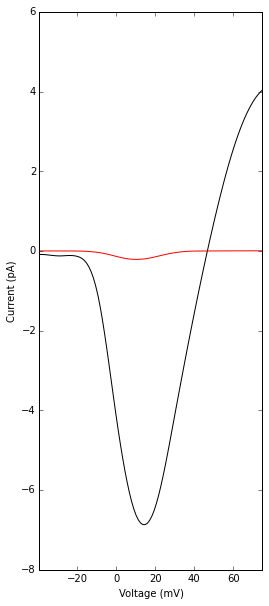

In [21]:
# Plot the interpolated I-V curves.  
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(v_new,i_obs_interp,color='k')
plt.plot(v_new,i_pred_interp,color='r')
plt.xlabel('Voltage (mV)')
plt.ylabel('Current (pA)')
plt.xlim(start,stop)
fig.set_size_inches(4,10)

In [22]:
# Sum of the difference between the curves.
sse = np.sum((i_obs_interp - i_pred_interp)**2)
print("The sum of the squared differences is %.4g mV^2" % sse)

The sum of the squared differences is 1197 mV^2
